# Basic Network Analysis

`Date: 26/12/2019`

`Author: James Smith`

In this notebook we will do some basic preprocessing and network visualisation/analysis. Currently we have a standard tablular dataset with independent rows. Thus, in order to do this we will need to think about how we want to represent it as a network. 

## Summary

- [This article](https://www.analyticsvidhya.com/blog/2018/04/introduction-to-graph-theory-network-analysis-python-codes/) is very useful for a quick overview of network analytics. 
- [This article](https://medium.com/@nikkisharma536/knowledge-graph-part-2-modelling-tabular-data-as-graph-cfe1e0ee18fe) goes into more detail on modelling tabular data as a graph.
    > Nodes represent important entities/subjects/objects in our graphs. By having multiple types of node we can take advantage of the connected nature of the graph. For example : if our data set contains data about user and places with some metadata/attributes about both, we will create nodes for User and Place, and connect these by some Relation/edge (eg. User LIVES-IN Place) .

## Identifying Nodes

### Seller (Seller ID)
(if phone numbers are available this would be better - perhaps there are several seller ID's per phone number).

**Node Attributes**
- Seller name
- Number of ads seller has
- Seller location (possibly a separate node)
- Seller registration date
- Seller type

### Ad (Ad ID)

**Node Attributes**
- Ad info

### Location
(county and town concatenated)

Ideally we would like more specific location like full address to create meaningfull links, but we will leave this in as a demonstration

**Node Attributes**
- None

Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

table_location = r"C:\Users\User\Documents\ITB Year 2\Text Analytics and Web Content Mining\Assignments\Assignment 3\github\DoneDeal_Analytics\data\ad_info_table.csv"

ad_info_table = pd.read_csv(table_location)

In [2]:
len(ad_info_table)

10007

## Quick Cleaning

We only are looking at Private Sellers and excluding rows with missing data that we will value later on.

In [65]:
# Only want Private Sellers and those with actual IDs and location
num_rows_original = len(ad_info_table)

data = ad_info_table

data = data[data["seller_type"] == "PRIVATE"]
# data = data.drop(indexNames, inplace = True)

data = data.dropna(subset = ['ad_id','seller_county', 'seller_county_town', 'seller_id'])

# Ad location column
data["seller_location"] = data["seller_county_town"] + ", " + data["seller_county"]

num_rows_clean = len(data)

print(str(num_rows_original-num_rows_clean), "rows removed")

data = data.sample(frac = 0.05)

4269 rows removed


In [66]:
len(data)

287

# Representing Pandas Dataframe as Network

**Networkx**

- `from_pandas_dataframe()` - https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.convert_matrix.from_pandas_dataframe.html
    - Needs to be fed an edge list representation of a graph
    
- `g.add_edges_from()` 
    - Ads list of edges to an empty graph
    
    
## Sellers also need to be connected to a location!!!!

## Simple Example and Plot

### List attributes as connections to all ads

In [67]:
data.columns

Index(['Unnamed: 0', 'ad_age', 'ad_currency', 'ad_description', 'ad_header',
       'ad_id', 'ad_price', 'ad_url', 'car_body_type', 'car_colour',
       'car_engine', 'car_fuel_type', 'car_make', 'car_mileage', 'car_model',
       'car_nct_expiry', 'car_num_doors', 'car_num_prev_owners',
       'car_reg_country', 'car_road_tax', 'car_transmission', 'car_year',
       'green_light_verified', 'seller_county', 'seller_county_town',
       'seller_id', 'seller_name', 'seller_num_ads', 'seller_phone_number',
       'seller_reg_date', 'seller_type', 'seller_location'],
      dtype='object')

In [68]:
import matplotlib.pyplot as plt
import networkx as nx

In [69]:
# Taken from https://codepunk.io/building-relationship-graphs-in-python-with-networkx/

# Define what we want to make nodes
node_types = ["ad_id", "seller_location", "seller_id"]

# Get all unique ads in the data frame
ad_id_list = data["ad_id"].unique().tolist()

#----- Get Nodes -----#

# Dictionary of node_types and the list of them
nodes_list_dict = {node_type : list(data[node_type].unique()) for node_type in node_types}

nodes = []

for node_type in node_types:
    nodes_list = nodes_list_dict[node_type]
    # Have list of specfic nodes for given type, loop over and append
    for node in nodes_list:
        nodes.append((node, {'node_type' : node_type}))

#---- Get Edges -----#

# Initialize list of edges
edges = []

for ad_id in ad_id_list:
    
    # Get a 1 row dataframe for specific ad
    ad = data[data["ad_id"] == ad_id]
    # Transpose to easily loop over columns
    ad_T = ad.transpose()

    for index, info in ad_T.iterrows():
        # Consider only node attributes
        if index in node_types:
            # Dictionary of edge data - can expand later
            edge_dict = {'ad_title' : ad["ad_header"].values[0],
                         'node_type' : index,
                         'node_value' : info.values[0]}
            # Tuple of ad_id and related info
            edges.append((ad_id, info.values[0], edge_dict))

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)


# Plot
# plt.figure(figsize = (20, 10))

# nx.draw(g, with_labels = True, node_size = 5000, font_size = 20)  
# plt.show() 

## Network Analysis

In [79]:
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
d = nx.degree_centrality(g)
for k in sorted(d, key = d.get, reverse = True):
    print(k, d[k])

South County, Dublin 0.03003003003003003
South City, Dublin 0.02702702702702703
North County, Dublin 0.02102102102102102
Limerick City, Limerick 0.013513513513513514
North City, Dublin 0.012012012012012012
Tralee, Kerry 0.01051051051051051
City Centre, Dublin 0.009009009009009009
Letterkenny, Donegal 0.009009009009009009
Cork City, Cork 0.009009009009009009
Waterford City, Waterford 0.009009009009009009
Derry City, Derry 0.009009009009009009
Ballina, Mayo 0.0075075075075075074
West County, Dublin 0.0075075075075075074
Galway City, Galway 0.0075075075075075074
23416832 0.006006006006006006
23682051 0.006006006006006006
22895621 0.006006006006006006
23137133 0.006006006006006006
23811080 0.006006006006006006
23710730 0.006006006006006006
23015767 0.006006006006006006
22560780 0.006006006006006006
23793683 0.006006006006006006
23756630 0.006006006006006006
23116824 0.006006006006006006
23669252 0.006006006006006006
23811099 0.006006006006006006
23809053 0.006006006006006006
23803936 0.006

554210 0.0015015015015015015
13646 0.0015015015015015015
2895186 0.0015015015015015015
1901907 0.0015015015015015015
24920 0.0015015015015015015
2511193 0.0015015015015015015
3082586 0.0015015015015015015
209244 0.0015015015015015015
1909648 0.0015015015015015015
557414 0.0015015015015015015
488808 0.0015015015015015015
3229034 0.0015015015015015015
2453223 0.0015015015015015015
10605 0.0015015015015015015
441714 0.0015015015015015015
884083 0.0015015015015015015
3229044 0.0015015015015015015
863608 0.0015015015015015015
298361 0.0015015015015015015
277884 0.0015015015015015015
1971584 0.0015015015015015015
263554 0.0015015015015015015
1319299 0.0015015015015015015
Kill, Kildare 0.0015015015015015015
3086729 0.0015015015015015015
285066 0.0015015015015015015
77207 0.0015015015015015015
3394967 0.0015015015015015015
Kilbeggan, Westmeath 0.0015015015015015015
3399066 0.0015015015015015015
2113942 0.0015015015015015015
Piltown, Kilkenny 0.0015015015015015015
247212 0.0015015015015015015
7

In [80]:
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
d = nx.betweenness_centrality(g)
for k in sorted(d, key = d.get, reverse = True):
    print(k, d[k])

South County, Dublin 0.003432003432003432
South City, Dublin 0.0027636659215606587
North County, Dublin 0.0016437490121700648
Limerick City, Limerick 0.0006502743344848609
North City, Dublin 0.0005057689268215584
Tralee, Kerry 0.0003183634762582131
Letterkenny, Donegal 0.000270947639368692
Cork City, Cork 0.000270947639368692
Waterford City, Waterford 0.000270947639368692
Derry City, Derry 0.000270947639368692
City Centre, Dublin 0.00021901600848969272
Ballina, Mayo 0.000180631759579128
West County, Dublin 0.000180631759579128
Galway City, Galway 0.000180631759579128
23811080 0.0001761159655896498
23585298 0.0001761159655896498
23631052 0.0001761159655896498
23018720 0.0001761159655896498
23463302 0.0001761159655896498
21202215 0.0001761159655896498
21134715 0.0001761159655896498
23680410 0.0001761159655896498
23300556 0.0001761159655896498
22482392 0.0001761159655896498
23786988 0.0001761159655896498
23513611 0.0001761159655896498
23761592 0.0001761159655896498
23640653 0.000176115965

800359 0.0
2997687 0.0
3306599 0.0
122476 0.0
559378 0.0
125551 0.0
31345 0.0
2428530 0.0
1478261 0.0
779901 0.0
1258113 0.0
137622 0.0
2064006 0.0
2304449 0.0
Killorglin, Kerry 0.0
1409677 0.0
Claremorris, Mayo 0.0
23183 0.0
2802146 0.0
193170 0.0
1992986 0.0
2569890 0.0
88739 0.0
3387047 0.0
Armagh Town, Armagh 0.0
2268103 0.0
2223790 0.0
179309 0.0
620209 0.0
862899 0.0
Bunclody, Wexford 0.0
373430 0.0
82616 0.0
735932 0.0
1496522 0.0
460478 0.0
11968 0.0
2773335 0.0
Arklow, Wicklow 0.0
73095 0.0
201419 0.0
636622 0.0
1212111 0.0
5841 0.0
2097176 0.0
2476153 0.0
488153 0.0
760540 0.0
518881 0.0
79589 0.0
2189031 0.0
37330 0.0
2695918 0.0
3161839 0.0
1869553 0.0
487891 0.0
571125 0.0
2213673 0.0
343803 0.0
1901696 0.0
819670 0.0
Roscommon Town, Roscommon 0.0
Trim, Meath 0.0
2744076 0.0
Wicklow Town, Wicklow 0.0
283106 0.0
263975 0.0
2255151 0.0
254748 0.0
531134 0.0
885540 0.0
58161 0.0
111068 0.0
2490154 0.0
141100 0.0
Cahersiveen, Kerry 0.0
76590 0.0
1418031 0.0
3393672 0.0
393694 

In [75]:
# Degree Centrality

def nodes_with_m_nbrs(G, m):
    """
    Returns all nodes in graph G that have m neighbors.
    """
    nodes = set()

    # Iterate over all nodes in G
    for n in G.nodes():

        # Check if the number of neighbors of n matches m
        if len(list(G.neighbors(n))) == m:

            # Add the node n to the set
            nodes.add(n)

    # Return the nodes with m neighbors
    return nodes

# Compute and print all nodes in T that have 6 neighbors
num_brs = 5
nodes_with_m_nbrs(g, num_brs)
print("Nodes with", num_brs, "neighbors: \n", nodes_with_m_nbrs(g, num_brs))

print(list(g.neighbors('Galway City, Galway')))

Nodes with 5 neighbors: 
 {'Galway City, Galway', 'Ballina, Mayo', 'West County, Dublin'}
[23150256, 22329072, 23321538, 23772149, 23745366]


In [76]:
# Betweenness Centrality

def find_nodes_with_highest_deg_cent(G):
 
    # Compute the degree centrality of G: deg_cent
    deg_cent = nx.degree_centrality(G)
 
    # Compute the maximum degree centrality: max_dc
    max_dc = max(list(deg_cent.values()))
 
    nodes = set()
 
    # Iterate over the degree centrality dictionary
    for k, v in deg_cent.items():
 
        # Check if the current value has the maximum degree centrality
        if v == max_dc:
 
            # Add the current node to the set of nodes
            nodes.add(k)
 
    return nodes
 
# Find the node(s) that has the highest degree centrality in T: top_dc
top_dc = find_nodes_with_highest_deg_cent(g)
print(top_dc)

{'South County, Dublin'}


Comments
- From first glance it doesn't seem like a very connected network, which is what one would expect
- It is hard to descern node types and to tell if there are sub networks greater than just 3 nodes
- RunTime Error with +4000 rows

## Trying to Create a Nicer Visualisation

Inspired by [this article](http://jonathansoma.com/lede/algorithms-2017/classes/networks/networkx-graphs-from-source-target-dataframe/)

In [83]:
if len(data) > 300:
    #----- Define Layout -----# 

    plt.figure(figsize=(12, 12))
    layout = nx.spring_layout(g,iterations=50)

    #----- Set up colours -----#

    # Taken from num 11 on https://visme.co/blog/website-color-schemes/
    pallet = ['#E7717D', '#AFD275', '#C2CAD0', '#7E685A']

    #----- Set up node dictionary and sizes -----#

    # Get a corresponding dictionary of node sizes based on its degree
    node_sizes_dict = {}
    for node_type in node_types:
        node_type_sizes = [g.degree(node_type) * 50 for node_type in nodes_list_dict[node_type]]
        node_sizes_dict[node_type] = node_type_sizes

    #----- Draw nodes and edges -----#

    # ad_id - doesn't have sizes
    nx.draw_networkx_nodes(g, 
                           layout, 
                           nodelist = nodes_list_dict['ad_id'], 
                           # node_size = node_sizes_dict['ad_id'],
                           node_size = 50,
                           node_color = pallet[0], 
                           label = 'Car Ads')

    # seller_id
    nx.draw_networkx_nodes(g, 
                           layout, 
                           nodelist = nodes_list_dict['seller_id'], 
                           node_size = node_sizes_dict['seller_id'], 
                           node_color = pallet[1], 
                           label = 'Sellers')

    # seller_location
    nx.draw_networkx_nodes(g, 
                           layout, 
                           nodelist = nodes_list_dict['seller_location'], 
                           node_size = node_sizes_dict['seller_location'], 
                           node_color = pallet[2], 
                           label = 'Location')

    nx.draw_networkx_edges(g, layout, width = 1)
    #nx.draw_networkx_edges(g, layout, width = 1, edge_color = pallet[3])

    #----- Draw Labels -----#

    node_labels = dict(zip(nodes_list_dict['seller_location'], nodes_list_dict['seller_location']))
    nx.draw_networkx_labels(g, layout, labels = node_labels, font_size = 14)

    # 4. Turn off the axis because I know you don't want it
    plt.axis('off')
    plt.legend(numpoints = 1)

    title = "Done Deal Network for " + str(len(data)) + " ads"
    plt.title(title, fontsize = 20)

    # 5. Tell matplotlib to show it
    plt.show()
    
else:
    print("Too many data points to plot!")

Too many data points to plot!


In [ ]:
# g.edges(data = True)

Things to note:
- It would be better to have the **ads on the outside**
- Seller connectedness proportional to size
- Edge colour different for more important people
- Labels on those who are important sellers
- Choose more appealing colours
- Considering exporting to Gephi
- Consider having as multidirectional graph (**might help with drawing issues**)
- Consider
- Map to a map of Ireland

## nx.fruchterman_reingold_layout

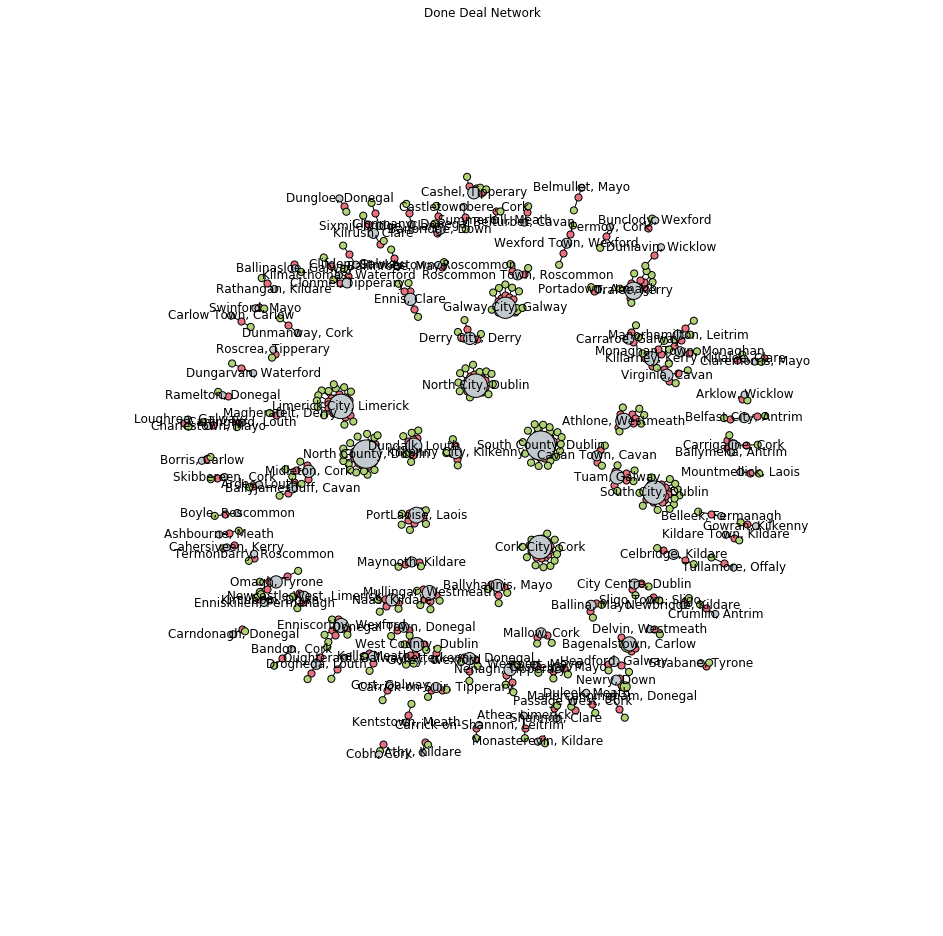

In [14]:
# #----- Define Layout -----# 

# plt.figure(figsize=(16, 16))
# layout = nx.fruchterman_reingold_layout(g,iterations=50)

# #----- Set up colours -----#

# # Taken from num 11 on https://visme.co/blog/website-color-schemes/
# pallet = ['#E7717D', '#AFD275', '#C2CAD0', '#7E685A']

# #----- Set up node dictionary and sizes -----#

# # Could find a way to add node data to graph - FUTURE WORK
# # Dictionary of node_types and the list of them
# nodes_list_dict = {node_type : list(data[node_type].unique()) for node_type in node_types}

# # Get a corresponding dictionary of node sizes based on its degree
# node_sizes_dict = {}
# for node_type in node_types:
#     node_type_sizes = [g.degree(node_type) * 50 for node_type in nodes_list_dict[node_type]]
#     node_sizes_dict[node_type] = node_type_sizes

# #----- Draw nodes and edges -----#

# # ad_id - doesn't have sizes
# nx.draw_networkx_nodes(g, 
#                        layout, 
#                        nodelist = nodes_list_dict['ad_id'], 
#                        # node_size = node_sizes_dict['ad_id'],
#                        node_size = 50,
#                        node_color = pallet[0])

# # seller_id
# nx.draw_networkx_nodes(g, 
#                        layout, 
#                        nodelist = nodes_list_dict['seller_id'], 
#                        node_size = node_sizes_dict['seller_id'], 
#                        node_color = pallet[1])

# # seller_location
# nx.draw_networkx_nodes(g, 
#                        layout, 
#                        nodelist = nodes_list_dict['seller_location'], 
#                        node_size = node_sizes_dict['seller_location'], 
#                        node_color = pallet[2])

# nx.draw_networkx_edges(g, layout, width = 1)
# #nx.draw_networkx_edges(g, layout, width = 1, edge_color = pallet[3])

# #----- Draw Labels -----#

# node_labels = dict(zip(nodes_list_dict['seller_location'], nodes_list_dict['seller_location']))
# nx.draw_networkx_labels(g, layout, labels = node_labels)

# # 4. Turn off the axis because I know you don't want it
# plt.axis('off')

# plt.title("Done Deal Network")

# # 5. Tell matplotlib to show it
# plt.show()

## circular_layout

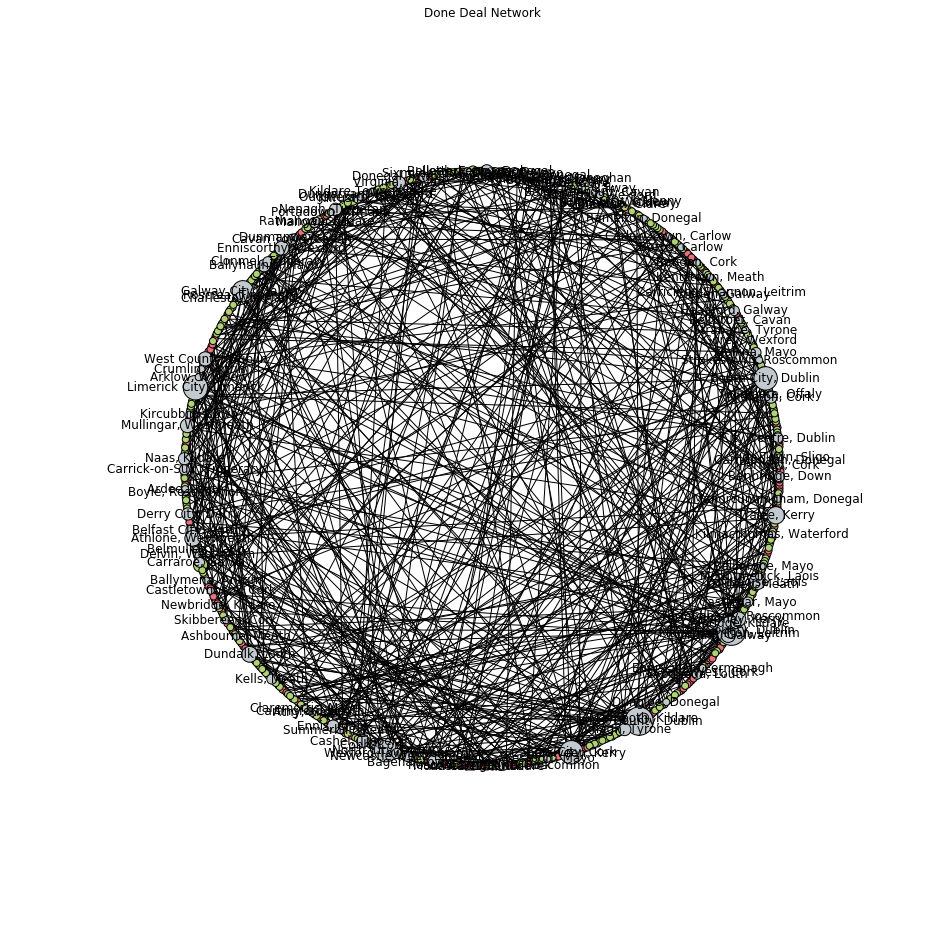

In [16]:
# #----- Define Layout -----# 

# plt.figure(figsize=(16, 16))
# layout = nx.circular_layout(g)

# #----- Set up colours -----#

# # Taken from num 11 on https://visme.co/blog/website-color-schemes/
# pallet = ['#E7717D', '#AFD275', '#C2CAD0', '#7E685A']

# #----- Set up node dictionary and sizes -----#

# # Could find a way to add node data to graph - FUTURE WORK
# # Dictionary of node_types and the list of them
# nodes_list_dict = {node_type : list(data[node_type].unique()) for node_type in node_types}

# # Get a corresponding dictionary of node sizes based on its degree
# node_sizes_dict = {}
# for node_type in node_types:
#     node_type_sizes = [g.degree(node_type) * 50 for node_type in nodes_list_dict[node_type]]
#     node_sizes_dict[node_type] = node_type_sizes

# #----- Draw nodes and edges -----#

# # ad_id - doesn't have sizes
# nx.draw_networkx_nodes(g, 
#                        layout, 
#                        nodelist = nodes_list_dict['ad_id'], 
#                        # node_size = node_sizes_dict['ad_id'],
#                        node_size = 50,
#                        node_color = pallet[0])

# # seller_id
# nx.draw_networkx_nodes(g, 
#                        layout, 
#                        nodelist = nodes_list_dict['seller_id'], 
#                        node_size = node_sizes_dict['seller_id'], 
#                        node_color = pallet[1])

# # seller_location
# nx.draw_networkx_nodes(g, 
#                        layout, 
#                        nodelist = nodes_list_dict['seller_location'], 
#                        node_size = node_sizes_dict['seller_location'], 
#                        node_color = pallet[2])

# nx.draw_networkx_edges(g, layout, width = 1)
# #nx.draw_networkx_edges(g, layout, width = 1, edge_color = pallet[3])

# #----- Draw Labels -----#

# node_labels = dict(zip(nodes_list_dict['seller_location'], nodes_list_dict['seller_location']))
# nx.draw_networkx_labels(g, layout, labels = node_labels)

# # 4. Turn off the axis because I know you don't want it
# plt.axis('off')

# plt.title("Done Deal Network")

# # 5. Tell matplotlib to show it
# plt.show()

## spectral_layout

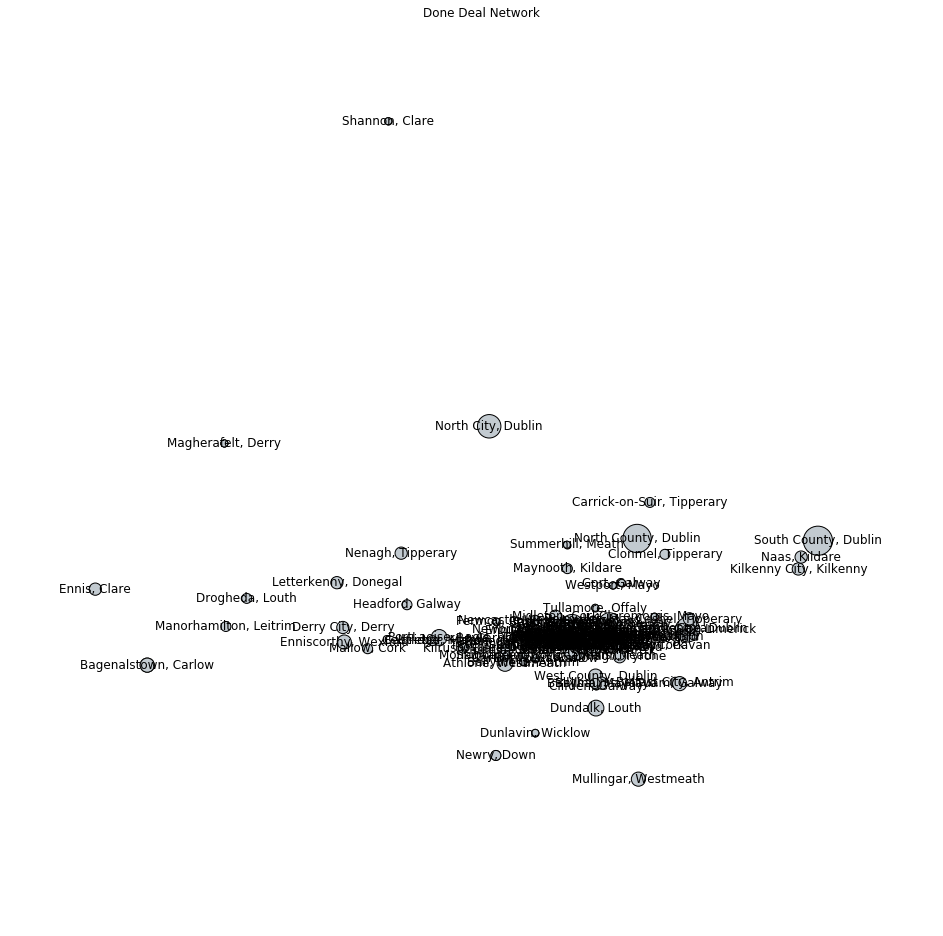

In [17]:
# #----- Define Layout -----# 

# plt.figure(figsize=(16, 16))
# layout = nx.spectral_layout(g)

# #----- Set up colours -----#

# # Taken from num 11 on https://visme.co/blog/website-color-schemes/
# pallet = ['#E7717D', '#AFD275', '#C2CAD0', '#7E685A']

# #----- Set up node dictionary and sizes -----#

# # Could find a way to add node data to graph - FUTURE WORK
# # Dictionary of node_types and the list of them
# nodes_list_dict = {node_type : list(data[node_type].unique()) for node_type in node_types}

# # Get a corresponding dictionary of node sizes based on its degree
# node_sizes_dict = {}
# for node_type in node_types:
#     node_type_sizes = [g.degree(node_type) * 50 for node_type in nodes_list_dict[node_type]]
#     node_sizes_dict[node_type] = node_type_sizes

# #----- Draw nodes and edges -----#

# # ad_id - doesn't have sizes
# nx.draw_networkx_nodes(g, 
#                        layout, 
#                        nodelist = nodes_list_dict['ad_id'], 
#                        # node_size = node_sizes_dict['ad_id'],
#                        node_size = 50,
#                        node_color = pallet[0])

# # seller_id
# nx.draw_networkx_nodes(g, 
#                        layout, 
#                        nodelist = nodes_list_dict['seller_id'], 
#                        node_size = node_sizes_dict['seller_id'], 
#                        node_color = pallet[1])

# # seller_location
# nx.draw_networkx_nodes(g, 
#                        layout, 
#                        nodelist = nodes_list_dict['seller_location'], 
#                        node_size = node_sizes_dict['seller_location'], 
#                        node_color = pallet[2])

# nx.draw_networkx_edges(g, layout, width = 1)
# #nx.draw_networkx_edges(g, layout, width = 1, edge_color = pallet[3])

# #----- Draw Labels -----#

# node_labels = dict(zip(nodes_list_dict['seller_location'], nodes_list_dict['seller_location']))
# nx.draw_networkx_labels(g, layout, labels = node_labels)

# # 4. Turn off the axis because I know you don't want it
# plt.axis('off')

# plt.title("Done Deal Network")

# # 5. Tell matplotlib to show it
# plt.show()